###  Implementación computacional del método FTCS para resolver el enfriamiento convectivo unidimensional no estacionario de una barra.

#### MOOC: Transferencia de Calor y Masa Computacional
#### Módulo 4, Clase 3


En esta clase, escribiremos la forma discretizada del problema a los valores iniciales y de contorno que gobierna el enfriamiento convectivo de una barra. Luego, implementaremos el método numérico FTCS en Python para resolver la ecuación diferencial parcial y condiciones de borde asociadas al PVIC. Finalmente, graficaremos el perfil de temperatura en seis distintos tiempos y analizaremos el sentido físico de la solución.

Se desea conocer el perfil de temperatura en una barra cilíndrica de aluminio de radio muy delgado y largo $L = 1 m$. Consideraremos la coordenada axial como $z$ y que la transferencia de calor ocurre únicamente en esta dirección.

* En $z = 0$, la barra se encuentra adherida a un cuerpo caliente muy grande cuya temperatura es constante e igual a $T_w = 400 K$. 
* En $z = L$, se puede despreciar la transferencia de calor axial ya que el área transversal de la barra es muy pequeña.
* En $t = 0$, que representa el comienzo del proceso, la temperatura de toda la barra es igual a $T_0 = 400 K$.
* A lo largo del tiempo, la barra se enfría por convección natural desde los alrededores caracterizada por un coeficiente de convección $h = 20 Wm^{-2}K^{-1}$ y una temperatura ambiente $T_{\infty} = 298 K$.
* La difusividad térmica de la barra es $\alpha = 9.586$ $\times$ $10^{-5}$ m $^{2}$ s $^{-1}$.
* El diámetro de la barra es $d_i = 5,08$ cm.
* El calor específico del aluminio es aproximadamente $\hat{c}_p = 897$ J / kg / K.

El balance diferencial de este sistema produce la siguiente ecuación diferencial parcial

$$ \frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial z^2} - \frac{4h}{\rho \hat{c}_p d_i} (T-T_{\infty}) $$

Sujeto a la condición inicial

CI: $T(z, t=0) = T_0 = 400 K$

Y las condiciones de borde:

CB1: $ T(z=0, t) = T_w = 400 K $

CB2: $  \frac{\partial T}{\partial z} (z=L, t) = 0 $

A continuación, procederemos con los siguientes pasos para resolver el PVIC:

1. Discretizar la ecuación diferencial resultante utilizando diferencias finitas en el espacio y el tiempo 
2. Implementar un algoritmo numérico para encontrar la solución al sistema durante los primeros 3600 segundos de proceso.

### Parte 1)

Utilizaremos el método FTCS. Sean $j$ y $j+1$ el tiempo de la iteración actual y el tiempo de la próxima iteración, respectivamente. Estos aparecerán en superíndices al lado de la variable discretizada. En los subíndices aparecerán los índices asociados a los nodos provenientes de la discretización espacial del dominio geométrico. Finalmente, notamos que el enfriamiento convectivo constituye un término de sumidero de calor. Al discretizar este término, la temperatura como variable continua se reemplaza por la temperatura del nodo central $ i $. Al aplicar el método FTCS, se obtiene la siguiente ecuación discretizada:

$$ \frac{T_i^{j+1}-T_i^{j}}{\Delta t} = \alpha \frac{T_{i+1}^j - 2 T_{i}^j + T_{i-1}^j}{\Delta z ^2} - \frac{4h}{\rho \hat{c}_p d_i} (T^{j}_i-T_{\infty})  $$

Reordenando términos, se obtiene la iteración para encontrar la evolución del sistema:

$$ T_i^{j+1} = T_i^{j} +  \Delta t \left( \alpha\frac{T_{i+1}^j - 2 T_{i}^j + T_{i-1}^j}{\Delta z ^2} - \frac{4h}{\rho \hat{c}_p d_i} (T^{j}_i-T_{\infty}) \right), \hspace{0.5cm} 1 \leq i \leq N_z - 1$$

Esta ecuación es válida para todos los nodos interiores. El primer y último nodo se denotan com $i = 0$ e $i = N_z$, respectivamente. Para estos nodos, la ecuación de evolución se encuentra determinada por las condiciones de borde del problema. Podemos escribir de forma matricial esta ecuación del siguiente modo,

$$ \mathbf{T}^{j+1} = \mathbf{T}^{j} + \Delta t \cdot (\mathbf{A} \mathbf{T}^{j} + \mathbf{b})  $$

Escribir esta iteración de forma matricial permite reducir enormemente el tiempo computacional requerido para calcular la solución. Esto se debe a que reemplazamos un bucle o `loop` de Python nativo por una multiplicación matricial en NumPy. Ya que gran parte del módulo NumPy se encuentra programado en un lenguaje de alto nivel como C++, esta multiplicación matricial es mucho más rápida.

### Parte 2) Implementación del método numérico

Importamos los módulos necesarios

In [2]:
%matplotlib notebook
# Computación científica
import numpy as np

# Gráficos
import matplotlib.pyplot as plt

# Mapas de colores
from matplotlib import cm

# Funciones especiales
from scipy.special import erf, erfc

Definimos la temperatura inicial y la temperatura en el extremo $z = 0$

In [3]:
# Temperatura inicial de la barra
T_0 = 400 # K

# Temperatura en z = 0
T_w = 400 # K

Definimos los parámetros físicos asociados a la ecuación diferencial parcial:

In [4]:
# Espesor de la barra
L = 1 #m

# Difusividad térmica
alpha = 9.586e-5 # m^2/s

# Densidad de la barra de aluminio
rho = 2700 # kg/m^3

# Calor específico a presión constante
c_p = 897 # J / kg / C

# Diámetro de la barra
d_i = 0.0254 # m

# Coeficiente de transferencia de calor por convección natural
h = 20 # W/m^2/K

Definimos los parámetros de simulación

In [5]:
# Número de nodos en la dimensión z
n_z = 101

# Espaciamiento de tiempo
dt = 0.5 # s

# Inicializar el reticulado (mesh)
z = np.linspace(0, L, n_z + 1)

# Espaciamiento del reticulado
dz = L/(n_z - 1)

# Condición inicial
T = np.ones(n_z + 1) * T_0

# Tiempo inicial
t_0 = 0

# Tiempo final
t_f = 3600 # s

Construimos la matriz de coeficientes y la rellenamos fila por fila para los nodos interiores. Estos coeficientes provienen de la discretización de la EDP.

In [6]:
# Creamos la matriz
A = np.zeros([n_z + 1, n_z + 1])

# Iteración

for i in range(1,n_z):
    # Coeficientes del nodo de la izquierda, (i-1)
    A[i, i-1] = alpha / (dz**2)
    
    # Coeficientes del nodo central, i
    A[i, i] = - 2 * alpha / (dz**2) - 4*h / (rho * c_p * d_i)
        
    # Coeficientes del nodo a la derecha, i + 1
    A[i, i+1] = alpha / (dz**2)    

Construimos el vector $b$ que tiene la misma dimensión de la temperatura,

In [7]:
# Temperatura del aire
T_inf = 298 # K

# Vector del lado derecho
b = np.ones(len(T)) * 4 * h / (rho * c_p * d_i) * T_inf

Discretizando la condición de borde de Dirichlet en $z = 0$, tenemos

$$ T^{j}_{0} = T_w $$

In [8]:
# Como la temperatura del primer nodo no cambia con el tiempo, el coeficiente asociado a esta temperatura en la matriz A es igual a cero
A[0,0] = 0

# También igualamos el vector del lado derecho a cero
b[0] = 0

Discretizando la condición de borde de Neumann en $z = L$, utilizando diferencias ce

$$ 3T^{j}_{N_z} - 4T^{j}_{N_z-1} + 1 T^{j}_{N_z-2}  = 0$$

In [9]:
# Segundo orden

A[-1, -1] = 3
A[-1, -2] = -4
A[-1, -3] = 1

# Se mantiene en cero porque es una CB homogenea
b[-1] = 0

Verificamos que la matriz dispersa utilizando el comando `ax.spy`

<IPython.core.display.Javascript object>


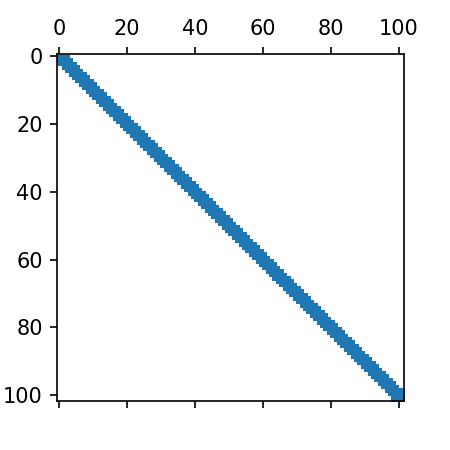

In [10]:
# Creamos un gráfico de 3 x 3
fig, ax = plt.subplots(1, 1, figsize = [3,3])

# Graficamos spy
ax.spy(A, markersize = 3)
plt.show()

En NumPy, al producto entre una matriz y un vector se calcula utilizando la sintaxis `np.dot(A,T)`. Antes de construir la iteración de la evolución de la temperatura, probamos la sintaxis para una iteración con el fin de validar intuitivamente la construcción de la matriz A

$$ \mathbf{T}^{j+1} = \mathbf{T}^{j} + \Delta t \cdot (\mathbf{A} \mathbf{T}^{j} + \mathbf{b})  $$

Donde `T_new` representa $\mathbf{T}^{j+1}$ y Donde `T` representa $\mathbf{T}^{j}$.

In [11]:
# Ejemplo de una iteración
T_new = T + (np.dot(A,T) + b) * dt

# Corregimos la condición de borde de segundo orden con una línea separada
T_new[-1] = (4* T_new[-2] - T_new[-3])/3

# Exploramos la variable
T_new

array([400.        , 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93367607,
       399.93367607, 399.93367607, 399.93367607, 399.93

Podemos notar que la temperatura de la barra descendió aproximadamente 0.1 K después de un paso de tiempo. Ahora estamos en condiciones de calcular el perfil de temperatura dependiente del tiempo:

In [12]:
# Tiempo inicial de integración
t = 0

# Tiempo final de integración
t_max = 1800

# Grabaremos los resultados después de 300 s:
write_interval = 300

# Lista en que se acumulan los tiempos donde se graban los perfiles de temperatura
t_vec = []

# Generamos una copia de la temperatura
T_old = np.copy(T)

# Lista con los perfiles de temperatura para cada write_interval
T_num = []

# Ecuación de evolución desde t = 0 hasta t max
while t < t_max:
    # Iteración de nuevas temperatura
    T_new = T_old + (np.dot(A,T_old) + b)*dt
    T_new[-1] = (4* T_new[-2] - T_new[-3])/3

    # Evolucionamos el tiempo
    t += dt
    # print(t)
    
    T_old = np.copy(T_new)
    
    # Guardamos el perfil de temperatura y el tiempo
    if (t%write_interval) < 0.9*dt:
        T_num.append(T_new)
        
        # Guardamos el tiempo
        t_vec.append(t)

Rutina para graficar

In [13]:
n_temp

6

<IPython.core.display.Javascript object>


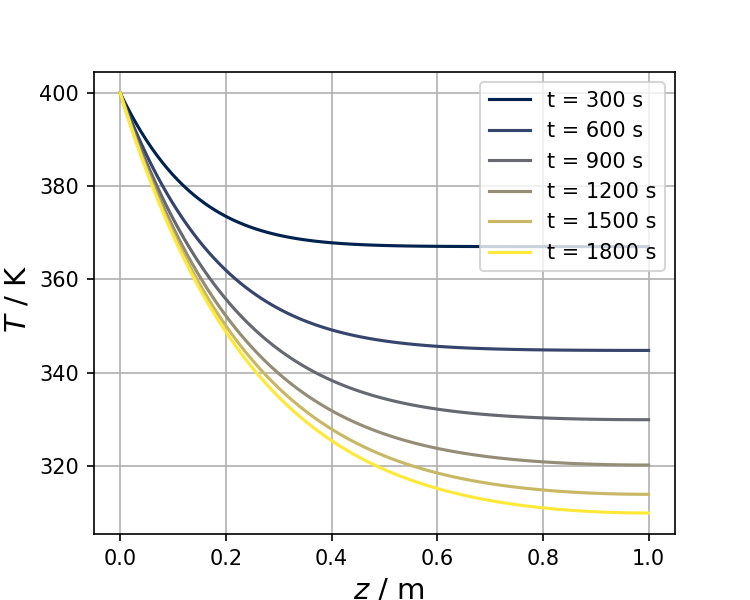

In [13]:
fig, ax = plt.subplots(1, 1, figsize = [5,4])

# Número de perfiles de temperatura totales a graficar
n_temp = len(T_num)

# Utilizar paleta de colores inclusiva
cividis = cm.get_cmap("cividis", n_temp)
colour = [cividis(i/n_temp) for i in range(n_temp)]
# colours = [cividis(0), cividis(1 / 7), cividis(2 / 7), cividis(3 / 7), cividis(4 / 7), cividis(5 / 7), cividis(6 / 7), cividis(1)]

for k in range(len(T_num)):
    plt.plot(z, T_num[k], color = colour[k], label = "t = %.0f s" % t_vec[k])

plt.xlabel(' $z$ / m', size = 14)
plt.ylabel(' $T$ / K', size = 14)
plt.grid()
plt.legend()
plt.show()

En esta clase, escribimos la forma discretizada del problema a los valores iniciales y de contorno que gobierna el enfriamiento convectivo de una barra. Luego, implementamos el método numérico FTCS en Python para resolver la ecuación diferencial parcial y condiciones de borde asociadas al PVIC. Finalmente, graficamos el perfil de temperatura en seis distintos tiempos y analizamos el sentido físico de la solución.